> **DO NOT EDIT IF INSIDE `caobd_s19` folder** 

# Assignment 2

**Handin in Peergrade**: *Monday*, October 21, 2019, 23:59<br>
**Peergrading deadline**: *Friday*, October 25, 2019, 23:59<br>
**Peergrading feedback deadline**: *Sunday*, October 27, 2019, 23:59

[**Feedback**](http://ulfaslak.com/vent)

## Problems

In [1]:
###Load Functions for Alliance Matrix

import re, os

#get alliances
def get_alliances(char, faction=None):
    """Return list of alliances for Marvel character."""
    
    if faction is None:
        for faction in ["heroes", "ambiguous", "villains"]:
            faction_chars = [c[:-4] for c in os.listdir("../data/%s" % faction)]
            if char in faction_chars:
                break
    
    # Load character markup
    with open("../data/%s/%s.txt" % (faction, char)) as fp:
        markup = fp.read()

    # Get alliance field
    alliances_field = re.findall(r"alliances[\w\W]+?\|.+=", markup)
    if alliances_field == []:
        return []

    # Extract teams from alliance field
    return [t[2:-1] for t in re.findall(r"\[\[.+?[\]\|]", alliances_field[0][10:])]

#create all teams list
import os
all_teams = []
characters = []
for faction in ["heroes", "villains", "ambiguous"]:
    characters += [c[:-4] for c in os.listdir("../data/%s" % faction)]

for ch in characters:
    try:
        ch_teams = get_alliances(ch)
    except FileNotFoundError:
        pass
    for team in ch_teams:
        if team not in all_teams:
            all_teams.append(team)

#team alliances function returns vector repr of team alliances for that character           
def team_alliances(COI, faction=None):
    '''takes the name of a character and returns a vector representaton of the team alliances for that character'''
    COIvector = []
    try:
        teamsCOI = get_alliances(COI)
        for team in all_teams:
            if team in teamsCOI:
                COIvector.append(1)
            else:
                COIvector.append(0)
    except FileNotFoundError:
        pass
    return COIvector


#create alliance matrix
import numpy as np
alliance_matrix = []
target_arraylist = []
herolist = []
villainlist = []
ambiguouslist = []
# make list of characters
characters = []
for faction in ["heroes", "villains", "ambiguous"]:
    if faction == "heroes":
        herolist += [c[:-4] for c in os.listdir("../data/%s" % faction)]
        characters += [c[:-4] for c in os.listdir("../data/%s" % faction)]
    if faction == "villains":
        villainlist += [c[:-4] for c in os.listdir("../data/%s" % faction)]
        characters += [c[:-4] for c in os.listdir("../data/%s" % faction)]
    if faction == "ambiguous":
        ambiguouslist += [c[:-4] for c in os.listdir("../data/%s" % faction)]


# making alliance matrix
for ch in characters:
    vector = team_alliances(ch)
    if sum(vector) > 0: 
        alliance_matrix.append(vector) # matrix with each character's alliance vector
        if ch in herolist:
            target_arraylist.append(1)
        elif ch in villainlist:
            target_arraylist.append(0)

alliance_matrix = np.asarray(alliance_matrix) # is this actually what its supposed to be
target_array = np.asarray(target_arraylist)

### Week 4

> **Ex. 4.3.2**: Implement cross validation. The performance of a classifier is strongly dependent on the amount of data it is trained on. In Ex. 4.3.1 you train it on only half of the data and test it on the other half. If you rerun that code multiple times, with random 50/50 partitions, you are gonna see a lot of uncertainty in performance. Cross validation solves this problem by training on a larger subset of the data and testing on a smaller one, and taking the average performance over K-folds of this process.
1. Implement cross validation over $K=10$ folds. For each fold you must record the training and test accuracies. In the end, visualize the distributions of test- and training accuracy as histograms in the same plot. It's important that you comment on the result.

In [179]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, precision_score

model = BernoulliNB()
model.fit(alliance_matrix, target_array) # training/fitting/learning step



BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [191]:
import random


# randomly reordering the characters
#need to correspond with each other, so must be same order
listorder = random.sample(range(len(alliance_matrix)), len(alliance_matrix))
reox = [alliance_matrix[i] for i in listorder] # Reordered X_ta
reoy = [target_array[i] for i in listorder] # Reordered y_ta
reox = np.array(reox)
reoy = np.array(reoy)

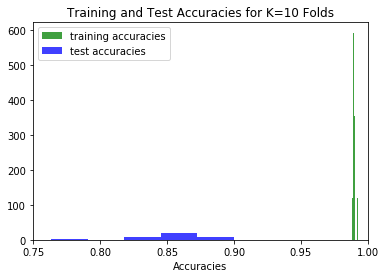

In [212]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
KF = KFold(n_splits=10)

training_accuracies = []
test_accuracies = []

for train, test in KF.split(reox): # implementing KFolds
    X_train, X_test = reox[train], reox[test]
    y_train, y_test = reoy[train], reoy[test]
    model.fit(X_train, y_train) # fitting model each time
    training_accuracies.append(model.score(X_train, y_train)) # adding accuracies of part of data used for training
    test_accuracies.append(model.score(X_test, y_test)) # adding accuracies of part of data used for testing

plt.hist(training_accuracies, alpha=0.75, bins='auto',density=True, stacked = True, color='g', label = "training accuracies")
plt.hist(test_accuracies, alpha=0.75, bins='auto', density=True, stacked = True, color='b', label = "test accuracies")
plt.title("Training and Test Accuracies for K=10 Folds")
plt.xlim(.75,1)
plt.xlabel("Accuracies")
plt.legend()
plt.show()

You get a high accuracy for the training accuracies because you are testing your model on its own data. It makes sense that the training accuracies are all higher than the test accuracies because the model is literally trained on that data so it is expected they are high. For the testing accuracy, it is still fairly good (all are above 0.8), but it is not as perfect as the training set. The training accuracies are normally distributed. The test accuracies seem to have more of a bimodel distristribution. 

>**Ex. 4.4.1**: Let's put our classifier to use!
* Retrain your model on all of your data.
* Create a team alliance representation of the ambiguous characters
* Use the model the estimate the probability that each character is a villain (let's call this *villainness*). You can use the `.predict_proba` method on the model to get probability estimates rather than class assignments.
* **Visualize the "heroness" distribution for all ambiguous characters**. Comment on the result.

(130, 622)


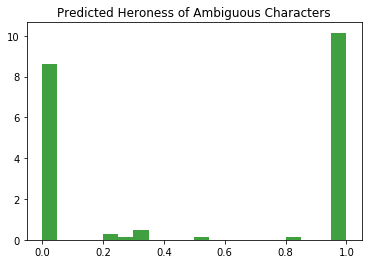

In [188]:
ambiguous_alliances = []
for ch in ambiguouslist: # 130 characters
    vector = team_alliances(ch)
    if sum(vector) > 0:
        ambiguous_alliances.append(vector) # matrix with each character's alliance vector
print(np.shape(ambiguous_alliances))

ambiguous_alliances = np.array(ambiguous_alliances)

model.fit(alliance_matrix, target_array)
predictions = model.predict_proba(ambiguous_alliances) # predictions character will be hero, villain
villainness = [pred[1] for pred in predictions]
heroness = [pred[0] for pred in predictions]

plt.hist(heroness, alpha=0.75, bins=20,density=True, stacked = True, color='g')
plt.title("Predicted Heroness of Ambiguous Characters")

plt.show()

The distribution is very polarized because the character is either a hero or a villain and cannot be in between. It is most likely to be around 0 or 1 because a given character that can be ambiguous is part of teams mostly comprised of villains or of heroes so it is generally easy to classify which class they are most likely a part of.

### Week 5

>**Ex. 5.1.3**: Print the maximum entropy path of a decision tree.
>
>1. Implement the following pseudocode and print the output:<br><br>
>Step 1. Find `team` that gives lowest split entropy for `data`. Print `team`.<br>
>Step 2. Split `data` on `team`, to produce `data0` and `data1`. Print the entropy of each, as well as their weighted avg. entropy.<br>
>Step 3. Overwrite the `data` variable with either `data0` or `data1`, depending on which has the highest entropy.<br>
>Step 4. Stop if there are less than 5 datapoints in `data`. Otherwise start over from 1.<br><br>
>My output looks [like this](http://ulfaslak.com/computational_analysis_of_big_data/exer_figures/example_6.2.3.1.png) for the first five splits.<br><br>
>
>2. Comment on decision path your code takes: How splits are there? Do you notice anything interesting about the final splits? Why do we choose to stop splitting before `data` get smaller than 5?
>3. Train a `sklearn.tree.DecisionTreeClassifier` classifier on the dataset. Initiate the classifier with `criterion='entropy'`. What are the most important features of this classifier? How does this line up with the order of the order of splits you just printed (a comment is fine)?

In [36]:
import math 

#shannon entropy function
def shannon_entropy(prob_array):
    split_entr = 0
    
    for prob in prob_array:
        if prob != 0:
            p = -1 * prob * math.log(prob,2)
            split_entr += p
        
    return split_entr

In [201]:
#partitioned entropy function
def partitioned_entropy(data, team):
    
    #get affiliated and non affiliated characters with given team
    affiliated = []
    not_affiliated =[]

    index = all_teams.index(team)
    team_array = alliance_matrix[ : , index]
    ind = 0

    #run through hero and villains data
    
    for char in characters:
        ind = characters.index(char)
        try:
            if team_array[ind] == 1:
                affiliated.append(char)
            else:
                not_affiliated.append(char)
        except IndexError:
            continue
        
    #split affiliated and non affiliated into heroes and villains
    #now you have lengths of subsets

    heroes_onteam = 0
    villains_onteam = 0 

    heroes_notaff = 0
    villains_notaff = 0
    
    #characterize into sub categories
    
    for char in affiliated: 
        index = characters.index(char)
        try:
            if target_array[index] == 1:
                heroes_onteam +=1
            else:
                villains_onteam +=1
        except IndexError:
            continue

    for char in not_affiliated: 
        index = characters.index(char)
        try:
            if target_array[index] == 1:
                heroes_notaff +=1
            else:
                villains_notaff +=1 
        except IndexError:
            continue
    
    #calculate probabilities
    
    #total count of characters
    total_count = heroes_onteam + villains_onteam + heroes_notaff + villains_notaff
    
    #probability array of heroes and villains affiliated with team
    try:
        onteam_prob_subset = [heroes_onteam/(villains_onteam+heroes_onteam), villains_onteam/(villains_onteam+heroes_onteam)]
    except ZeroDivisionError:
        return 0
    
    #probability array of heroes and villains not affiliated
    try: 
        non_prob_subset = [heroes_notaff/(villains_notaff+heroes_notaff), villains_notaff/(villains_notaff+heroes_notaff)]
    except ZeroDivisionError:
        return 0
    
    #get weighted average entropy
    average = (heroes_onteam * shannon_entropy(onteam_prob_subset))/total_count + (villains_onteam * shannon_entropy(onteam_prob_subset))/total_count + (heroes_notaff * shannon_entropy(non_prob_subset))/total_count + (villains_notaff * shannon_entropy(non_prob_subset))/total_count

    return average

In [194]:
#finds team with the lowest entropy
def lowest_team(teams):
    lowest_team = ''
    lowest_entropy = 1000
    
    #run through through all teams and replace lowest team if entropy is lower
    for team in teams_part:
        entropy = partitioned_entropy(alliance_matrix, team)
        if entropy == 0:
            continue
        else:
            if entropy < lowest_entropy:
                lowest_entropy = entropy
                lowest_team = team
    
    return lowest_team
           

In [204]:
#calculates split entropy. returns split entropy, weighted entropy, and new data sets
def split_entropy(data, team):
    
    global data0
    global data1
    
    data0 = []
    data1 = []
    #get affiliated and non affiliated characters with given team
    char0 = []
    char1 = []
   
    #in data0 i need the character's row so alliance_matrix[ind, :]
    index = teams_part.index(team)
    
    team_array = data[ :, index]
    ind = 0
    #run through hero and villains data
    
    for char in characters:
        ind = characters.index(char)
        try: 
            if team_array[ind] == 1:
                char0.append(char)
                data0.append(np.asarray(data[ind]))
            else:
                char1.append(char)
                data1.append(np.asarray(data[ind]))
        except IndexError:
            continue

    data0 = np.asarray(data0)
    data1 = np.asarray(data1)   
    #split affiliated and non affiliated into heroes and villains
    #now you have lengths of subsets
 
    
    heroes_onteam = 0
    villains_onteam = 0 

    heroes_notaff = 0
    villains_notaff = 0
    
    #index characters into heroes & villains based on if on team
    for char in char0: 
        index = characters.index(char)
        if target_array[index] == 1:
            heroes_onteam +=1
        else:
            villains_onteam +=1
    

    for char in char1: 
        index = characters.index(char)
        try:
            if target_array[index] == 1:
                heroes_notaff +=1
            else:
                villains_notaff +=1 
        except IndexError:
            continue
   
    #create subset probabilities based on class over total
    divisor = villains_onteam+heroes_onteam
    divisor1 = villains_notaff+heroes_notaff
    if divisor == 0:
        onteam_subset = [0,0]
    else: 
        onteam_subset = [heroes_onteam/(divisor), villains_onteam/(divisor)]
    
    if divisor1 == 0: 
        notaff_subset = [0,0]
    else:
        notaff_subset = [heroes_notaff/(divisor1), villains_notaff/(divisor1)]

    
    onteam_entropy = shannon_entropy(onteam_subset)
    notaff_entropy = shannon_entropy(notaff_subset)
    

    #total count of characters
    total_count = heroes_onteam + villains_onteam + heroes_notaff + villains_notaff
    
    #probability array of heroes and villains affiliated with team
   
    #divisor = villains_onteam+heroes_onteam
    if divisor == 0:
        onteam_prob_subset = [0,0]
    else: 
        onteam_prob_subset = [heroes_onteam/(divisor), villains_onteam/(divisor)]
   
    
    #probability array of heroes and villains not affiliated
   # divisor1 = villains_notaff+heroes_notaff
    if divisor1 == 0: 
        non_prob_subset = [0,0]
    else:
        non_prob_subset = [heroes_notaff/(divisor1), villains_notaff/(divisor1)]
    
    
    #get weighted average entropy
    average = (heroes_onteam * shannon_entropy(onteam_prob_subset))/total_count + (villains_onteam * shannon_entropy(onteam_prob_subset))/total_count + (heroes_notaff * shannon_entropy(non_prob_subset))/total_count + (villains_notaff * shannon_entropy(non_prob_subset))/total_count
    
    teams_part.remove(team)
    
    print("%s: \n data 0: \n    size %d \n    entropy %f \n data 1: \n    size: %d \n    entropy: %f \n average entropy: %f" % (team, len(data0), onteam_entropy, len(data1), notaff_entropy, average))
    
    if onteam_entropy > notaff_entropy:
        return data0
    else: 
        return data1



In [205]:
#create version so deletes lowest team from all teams
teams_part = all_teams.copy()
data = alliance_matrix
splits = 0

#run through data and split lowest team based on highest split entropy from previous split
#loop until data is less than 5
while len(data) >= 5:
    lowestteam = lowest_team(data)
    data = split_entropy(data, lowestteam)
    splits +=1
    
print(splits)

Avengers (comics): 
 data 0: 
    size 92 
    entropy 0.304587 
 data 1: 
    size: 1004 
    entropy: 0.993116 
 average entropy: 0.935320
X-Men: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 1004 
    entropy: 0.995863 
 average entropy: 0.995863
Masters of Evil: 
 data 0: 
    size 11 
    entropy 0.000000 
 data 1: 
    size: 993 
    entropy: 0.996907 
 average entropy: 0.985985
Sinister Six: 
 data 0: 
    size 1 
    entropy 0.000000 
 data 1: 
    size: 992 
    entropy: 0.994572 
 average entropy: 0.993570
New Warriors: 
 data 0: 
    size 8 
    entropy 0.543564 
 data 1: 
    size: 984 
    entropy: 0.994985 
 average entropy: 0.991344
Defenders (comics): 
 data 0: 
    size 3 
    entropy 0.918296 
 data 1: 
    size: 981 
    entropy: 0.993225 
 average entropy: 0.992996
X-Force: 
 data 0: 
    size 7 
    entropy 0.000000 
 data 1: 
    size: 974 
    entropy: 0.993555 
 average entropy: 0.986465
Lethal Legion: 
 data 0: 
    size 12 
    entropy 0.413

Purifiers (Marvel Comics): 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
New Enforcers: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
Elders of the Universe: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
Mandarin's Minions: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
Skeleton Crew (comics): 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
A-Force: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
A-Next: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
Captain Britain Corps: 
 data 0: 
    size 0 
 

Hood (comics): 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
Fearsome Foursome (comics): 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
Externals: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
Ani-Men: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
Wild Pack: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
Inhumans: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
Mercs for Money: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 6 
    entropy: 0.000000 
 average entropy: 0.000000
Infinity Watch: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
  

Hellions (Marvel Comics): 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 5 
    entropy: 0.000000 
 average entropy: 0.000000
Fantastic Four Incorporated: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 5 
    entropy: 0.000000 
 average entropy: 0.000000
Marvel Super Hero Contest of Champions: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 5 
    entropy: 0.000000 
 average entropy: 0.000000
Teen Brigade: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 5 
    entropy: 0.000000 
 average entropy: 0.000000
List of X-Men members#Street Team X-Men (2004): 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 5 
    entropy: 0.000000 
 average entropy: 0.000000
Thunderiders: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 5 
    entropy: 0.000000 
 average entropy: 0.000000
S.H.I.E.L.D: 
 data 0: 
    size 0 
    entropy 0.000000 
 data 1: 
    size: 5 
    entropy: 0.000000 
 average entropy:

There were 211 splits in total. After 26 splits the data was split to 7 data points and after that point all entropies computed were 0 and it took almost 200 more splits until the data dipped under 5. If we continued to split, it may have taken many many more splits until we reached the end of the data. It does not seem to be productive to make that many more splits. 

In [184]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='entropy')
model.fit(alliance_matrix, target_array) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Min_samples_split is important because it defines what the minimum number of samples required is to split an internal node. As we saw above, we only want to split if there are 5 or more data points or it can run into problems. Also want to look at max_features at each split because you want to expand on the node with a higher entropy. 

403


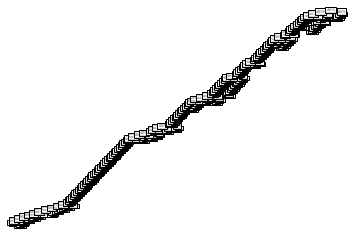

In [186]:
#not toally sure we actually had to plot tree but just in case...
from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()

tree.plot_tree(model)  
print(len(tree.plot_tree(model)))

### Week 6

> **Ex. 6.1.1**: Go to the `NetworkX` project's [tutorial page](https://networkx.github.io/documentation/stable/tutorial.html). Read the first few sections about nodes, edges and attributes. Write an example below where you create a graph, `G`, and then:
1. add some nodes and edges to,
2. print its nodes and edges
3. delete a node, and
4. plot it.

In [131]:
import networkx as nx

#create simple network
G = nx.Graph()
L = [1,2,3,4,5]
#add nodes
G.add_nodes_from(L)
G.add_edges_from([(1, 4), (1, 3), (2, 3), (4, 5), (2,4)])
print(G.nodes())
print(G.edges())
#remove nodes
G.remove_node(3)
print(G.nodes())

[1, 2, 3, 4, 5]
[(1, 4), (1, 3), (2, 3), (2, 4), (4, 5)]
[1, 2, 4, 5]


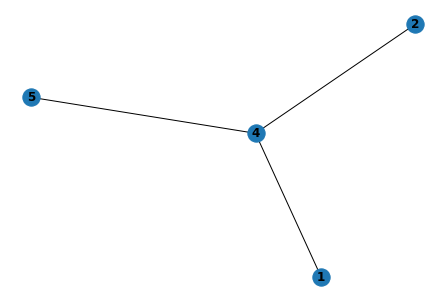

In [132]:
import matplotlib.pyplot as plt

#draw network
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

> **Ex. 6.1.3**: Another very famous type of synthetic network is the Barabási–Albert (BA) network.
1. Describe what a BA network is and how to create one.
2. On the [`NetworkX` documentations site](https://networkx.github.io/documentation/networkx-2.2/reference/generators.html), find a method you can use for generating a BA network. Create one with $N=100$ nodes and number of new edges from each new node $m=2$.
3. Plot the network
4. Visualize the [degree distribution](https://en.wikipedia.org/wiki/Degree_distribution) of your newly created BA graph.
5. Explain the main difference(s) you observe, when comparing to the ER network.
6. Are there other measures we could have used to describe the ER and BA networks further?

A BA network is a model that generates step wise creation of a network in which there is a new node at each time step with random connections. 

1. Start with m0 nodes where links between them are chosen arbitrarily and each node has at least one link
2. At each timestep, add a new node with m (≤ m0) links that connect the new node to m nodes already in the network. 

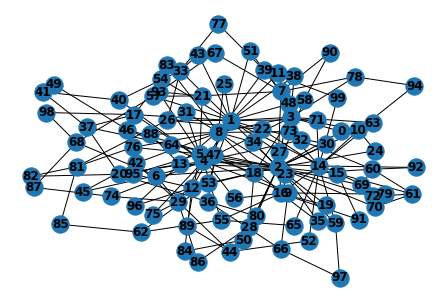

In [133]:
BA = nx.barabasi_albert_graph(100, 2)
#create BA network
nx.draw(BA, with_labels=True, font_weight='bold')

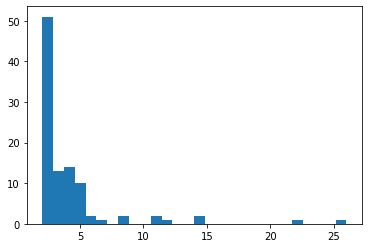

In [134]:
import matplotlib.pyplot as plt


BA_degree = list(BA.degree())

BA_plotting = []

for k in BA_degree:
    BA_plotting.append(k[1])


plt.hist(BA_plotting, bins='auto')
plt.show()

There has a heavy skew to the right meaning that for the most part in the BA network there are many nodes with a small degree and few with a large degree. 

You could generate a degree probability distribution which shows the probability of a node having a given degree. 

> **Ex: 6.2.2**: Create a `networkx.Graph` that represents each partnership between characters, as an edge. Print the number of nodes, edges and average degree of the resulting network.

In [135]:
import re, os

def get_partners(char, faction=None):
    """Return list of alliances for Marvel character."""
    if faction is None:
        for faction in ["heroes", "ambiguous", "villains"]:
            faction_chars = [c[:-4] for c in os.listdir("../data/%s" % faction)]
            if char in faction_chars:
                break
    
    # Load character markup
    with open("../data/%s/%s.txt" % (faction, char)) as fp:
        markup = fp.read()
        
    # Get partners field
    partners_field = re.findall(r"\| *partners[\w\W]+?\|.+=", markup)
    if partners_field == []:
        return []
 
    # Extract links from partners field
    return [t[2:-1] for t in re.findall(r"\[\[.+?[\]\|]", partners_field[0])]

get_partners("Iron Man")

['War Machine', 'Pepper Potts', 'Riri Williams']

In [136]:
#making full character list
chars = []
for faction in ["heroes", "ambiguous", "villains"]:
    chars += [c[:-4] for c in os.listdir("../data/%s" % faction)]

In [137]:
P = nx.Graph()
#G.add_nodes_from(chars)
for c in chars:
    #print("character:", c)
    if len(get_partners(c))>0: 
        for p in get_partners(c):
            P.add_edge(c, p)
print("number of nodes:", len(P.nodes()))
print("number of edges:",len(P.edges()))
degreesP = []
c_degrees = {}
#print(ER.edges)
for node in P:
    degreeP = 0
    for edge in P.edges:
        if node in edge:
            degreeP+=1
    c_degrees[node] = degreeP
    degreesP.append(degreeP)
avg_degree = sum(degreesP)/len(degreesP)
print(avg_degree)
#nx.draw(P, with_labels=False, font_weight='bold')
#plt.show()

number of nodes: 473
number of edges: 464
1.9619450317124736


> **Ex: 6.2.3**: Plot the degree distribution of your character network. What type of random network does it resemble?

(array([377.,  35.,  43.,   7.,   4.,   2.,   1.,   1.,   1.,   2.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <a list of 10 Patch objects>)

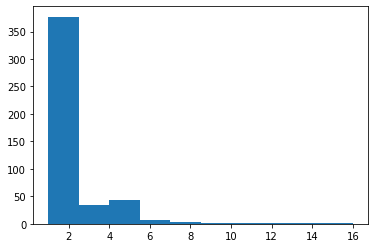

In [138]:
plt.hist(degreesP)

It resembles a BA network.

> **Ex: 6.2.7**: Let's make a nice plot of the network.I built a Python library called Netwulf (go `pip install netwulf`) that allows you to interactively plot networks in Python. Go ahead and produce a beautiful looking network using that! Comment on what you see.

In [1]:
pip install netwulf

     |████████████████████████████████| 245kB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 81kB 1.9MB/s eta 0:00:01
  Stored in directory: /Users/baileyheit/Library/Caches/pip/wheels/ce/f5/07/8e0fe9804591eb4df232c0b89514af7fb1bae57ac75d82bcb9
  Stored in directory: /Users/baileyheit/Library/Caches/pip/wheels/5d/1a/1e/0350bb3df3e74215cd91325344cc86c2c691f5306eb4d22c77
Successfully built netwulf simplejson
Note: you may need to restart the kernel to use updated packages.


({'xlim': [0, 643],
  'ylim': [0, 643],
  'linkColor': '#00e2ff',
  'linkAlpha': 0.30671948803900656,
  'nodeStrokeColor': '#ff0303',
  'nodeStrokeWidth': 2.821867190069948,
  'links': [{'source': 'Hawkeye (Kate Bishop)',
    'target': 'Hawkeye (comics)',
    'width': 7.687312923982555,
    'weight': 1},
   {'source': 'Hawkeye (comics)',
    'target': 'Black Widow (Natasha Romanova)',
    'width': 7.687312923982555,
    'weight': 1},
   {'source': 'Hawkeye (comics)',
    'target': 'Mockingbird (Marvel Comics)',
    'width': 7.687312923982555,
    'weight': 1},
   {'source': 'Hawkeye (comics)',
    'target': 'Swordsman (comics)',
    'width': 7.687312923982555,
    'weight': 1},
   {'source': 'Siryn',
    'target': 'Black Tom Cassidy',
    'width': 7.687312923982555,
    'weight': 1},
   {'source': 'Siryn',
    'target': 'Juggernaut (comics)',
    'width': 7.687312923982555,
    'weight': 1},
   {'source': 'Black Tom Cassidy',
    'target': 'Juggernaut (comics)',
    'width': 7.68731292

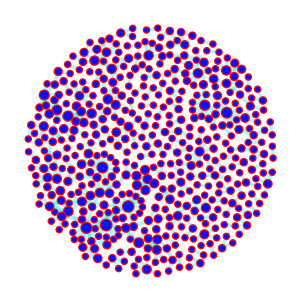

In [140]:
import networkx as nx
from netwulf import visualize

visualize(P)

The network visual produce resembles a circles with blue circles with a red frame, varying in size based on degree strength. There are some dots that have a high degree and others that do not. It almost looks like a beautiful microorganism. When you hover over a specific cell the name of the character appears. 